# Fitting Time-domain Fluorescence Decay

In [1]:
from TCSPC import *
plt.rcParams['figure.constrained_layout.use'] = True

In [2]:
#Initialize Simulation Objects (Phasor is a subclass which inherit everything from Simulation class)
NADH     = Phasor([0.75,0.25],[0.4,4])         #NADH object
EGFP     = Phasor([0.497,0.503],[2.43,3.07])   #EGFP object
mCherry  = Phasor([0.83,0.17],[1.43,2.38])     #mCherry object
sim_list = [NADH,EGFP,mCherry]
sim_name = ['NADH','EGFP','mCherry']
for i in range(3):
    sim_list[i].name = sim_name[i] #add name attributes to objects

## Important update: use Powell (`powell`) instead of Constrained Optimization by Linear Approximation (`cobyla`)
### Error bars

The data is rescaled such that the first data point $y_0$ is 1, i.e. $\tilde{y} = y/y_0$\
Error in rescaled data $\tilde{y}$:
$$\Delta \tilde{y} = \tilde{y} \cdot \sqrt{\left(\frac{\Delta y}{y}\right)^2+\left(\frac{\Delta y}{y_0}\right)^2}$$ 
where $\Delta y = \sqrt{y}$ as it is Poissonian noise.\
Hence $$\Delta \tilde{y} = \frac{y}{y_0}\sqrt{\frac{1}{y}+\frac{1}{y_0}}$$

### Normalized residuals

Normalized residuals $R_n$ are defined as: 
$$R_n = \frac{y-y_{\text{fit}}}{\Delta y}$$

and $\chi^2$ is defined as:
$$\chi^2 = \sum_i R_{ni}^2 = \sum_i \left(\frac{y_i-y_{\text{fit}} (x_i)}{\Delta y_i}\right)^2 $$
where $i$ denotes the $i$ th data point, $y_{\text{fit}}(x_i)$ is the fitting model.

Reduced $\chi^2$ = $\chi^2/\nu$, where the degree of freedom $\nu =$ no. of data points $-$ no. of fit parameters 

In [3]:
sim = EGFP
sim.repeat_sim_results() #produce info_df, par_df (dataframe of fit results) and fit_results (list ModelResult objects from lmfit)
info_df,par_df = fit_df(sim.fit_results)

/var/folders/vh/bwtbn9cn1xlbm74kxlygt5b80000gn/T/ipykernel_17943/2632679571.py:3: RuntimeWarning: divide by zero encountered in divide
  EGFP.fit(exp2,weights =1/np.sqrt(EGFP.y2[10:]))


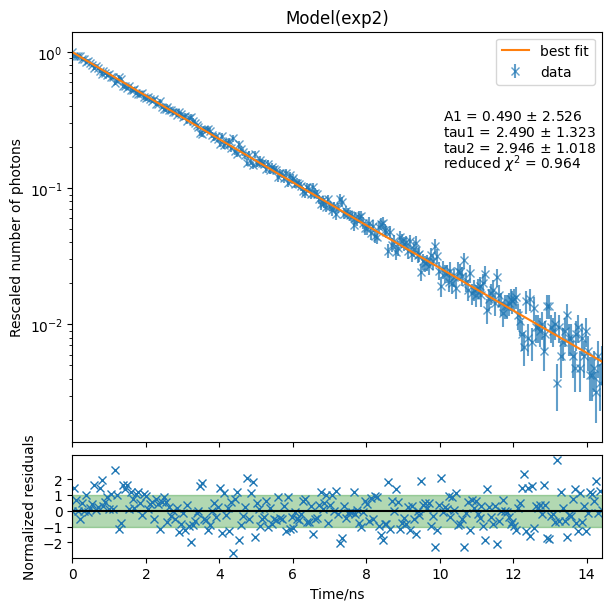

In [4]:
EGFP.n_photon = int(1e5)
EGFP.multi_exp_data()
EGFP.fit(exp2,weights =1/np.sqrt(EGFP.y2[10:]))
fig,ax = plot_fit(EGFP.fit_result)

### MLE minimizer result can be accessed through EGFP.mi1

In [70]:
def plot_mle(result,tdata =EGFP.t,ydata = EGFP.y2 ):
    '''INPUT: minimizer result'''
    fig,ax = plt.subplots(2,1,figsize = (6,6),gridspec_kw = {'height_ratios':[4,1]},sharex = True)
    tdata,ydata,weights = trim_rescale_data(tdata,ydata,rescale = False,)
    ax[0].errorbar(tdata,ydata,yerr = 1/weights,fmt = 'x',zorder = 1,alpha = 0.7) #original data
    ax[0].plot(tdata,exp_N(tdata,result.params),zorder = 2)
    ax[0].set_yscale('log')
    for i in range(len(EGFP.mi1.params.values())):
        t_text = tdata[-1]*0.6
        y_text = np.logspace(np.log10(min(ydata)),np.log10(max(ydata)),100)
        ax[0].text(t_text,y_text[80-5*i],[v.name + rf' = {v.value:0.3f} $\pm$ {v.stderr:0.3f}' for v in result.params.values()][i])
    ax[0].text(t_text,y_text[80-5*5],rf'reduced $\chi^2$ = {result.redchi:0.3f}')
    ax[0].set_title('MLE Fitting (Powell)')
    ax[1].set_ylabel('Normalized residuals')
    ax[1].plot(tdata,result.residual,'x')
    ax[1].axhline(0,c='k')
    ax[1].add_patch(mpl.patches.Rectangle((0,-1),tdata[-1],2,alpha = 0.3,color='g'))
    ax[1].set_yticks([-2,-1,0,1,2])
    for i in range(2):
        ax[i].set_xlim([0,tdata[-1]])
    ax[0].set_ylabel('Number of photons')
    ax[1].set_xlabel('Time/ns')
    ax[0].set_xlabel('')




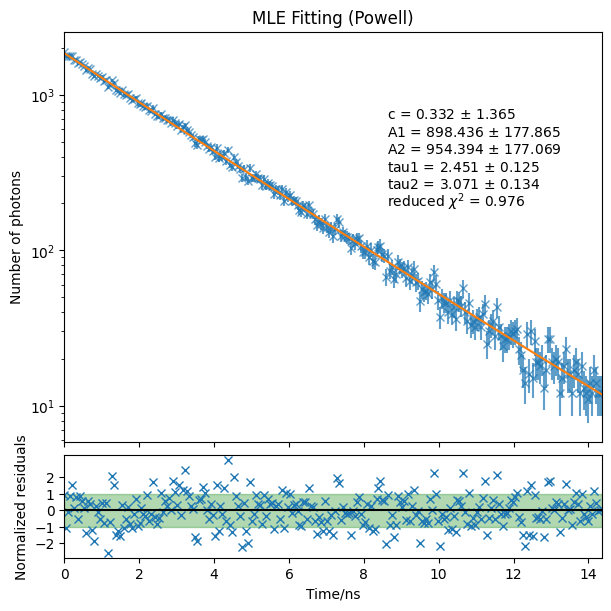

In [67]:
plot_mle(EGFP.mi1)

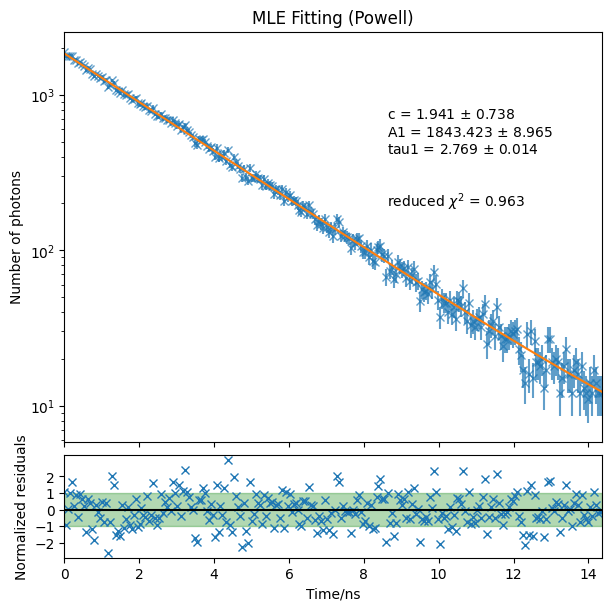

In [71]:
df = EGFP.MLEfit(1,EGFP.t,EGFP.y2)
plot_mle(EGFP.mi1)

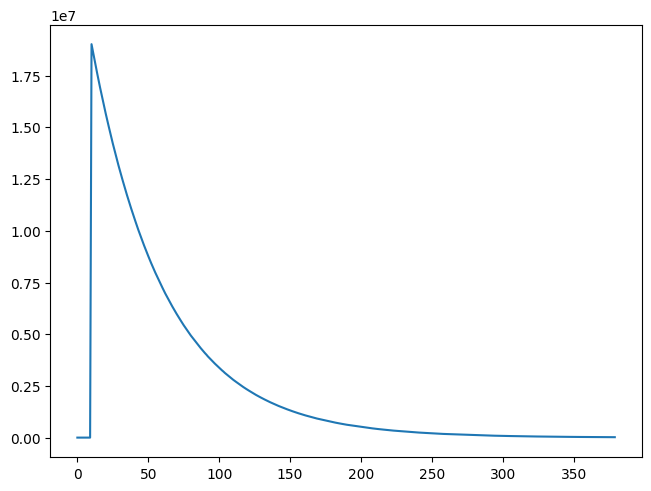

In [78]:
plt.plot(EGFP.y2)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])


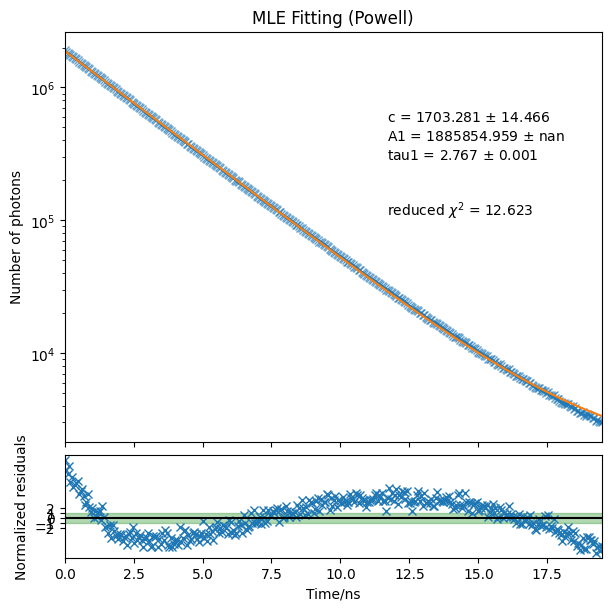

In [82]:
EGFP.n_photon = int(1e8)
EGFP.multi_exp_data()
EGFP.MLEfit(1,EGFP.t,EGFP.y2,rescale = False)
plot_mle(EGFP.mi1,ydata = EGFP.y2)

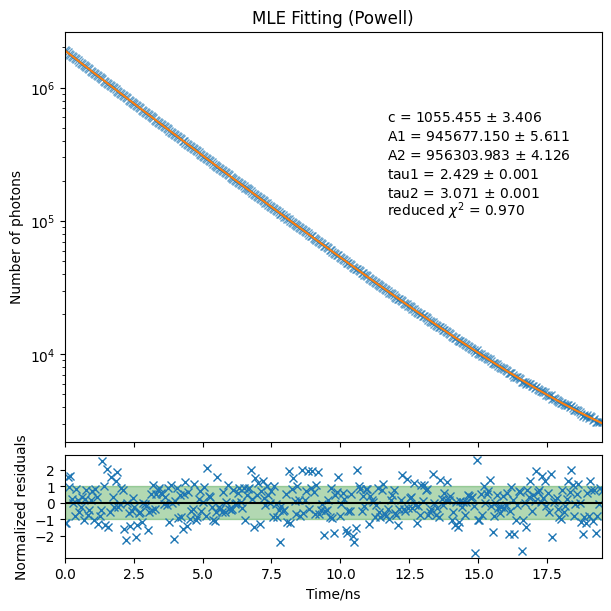

In [83]:
EGFP.n_photon = int(1e8)
EGFP.multi_exp_data()
EGFP.MLEfit(2,EGFP.t,EGFP.y2,rescale = False)
plot_mle(EGFP.mi1,ydata = EGFP.y2)

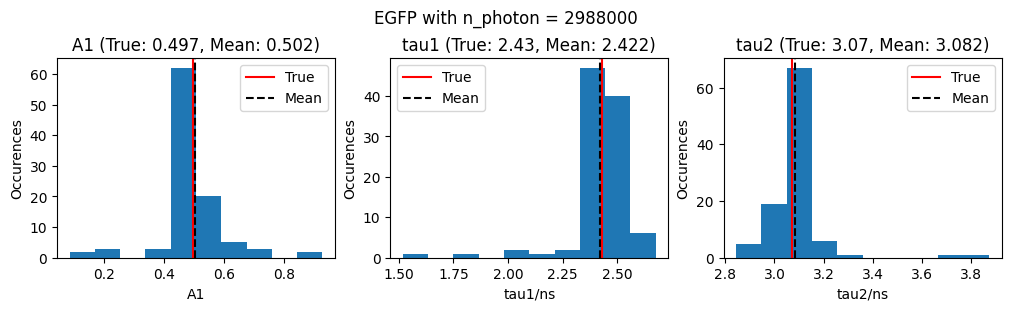

In [5]:
def plot_hist(sim):
    '''Plot histograms of fitted parameters of 100 simulations
       Input: Simulation object'''
    true_list = [sim.amp[0]]+sim.tau
    fig,ax = plt.subplots(nrows=1,ncols=3,figsize = (10,3))
    fig.suptitle(f'{sim.name} with n_photon = {EGFP.n_photon}')
    for i in range(3):
        mean = np.mean(EGFP.val_df.iloc[:,i])
        ax[i].set_title(EGFP.val_df.columns[i]+f' (True: {true_list[i]}, Mean: {mean:0.3f})')
        ax[i].set_xlabel(EGFP.val_df.columns[i]+['','/ns','/ns'][i])
        ax[i].set_ylabel('Occurences')
        ax[i].hist(EGFP.val_df.iloc[:,i])
        ax[i].axvline(true_list[i],c='r',label = 'True')
        ax[i].axvline(mean,c='k',ls='--',label = 'Mean')
        ax[i].legend()
    #ax[2].hist(EGFP.val_df.iloc[:,2])#,bins=np.arange(2,4,0.2))
    return fig,ax

fig,ax = plot_hist(EGFP)

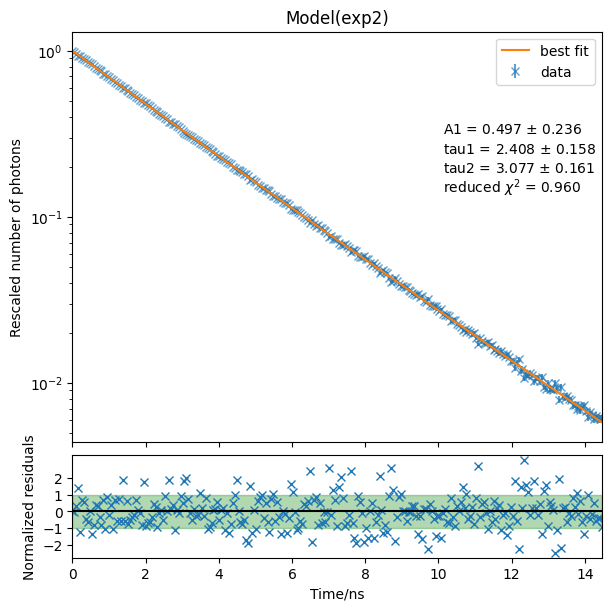

In [6]:
result = EGFP.fit_results[0]
fig,ax = plot_fit(result)

In [7]:
EGFP.repeat_sim_results(method = 'leastsq')
info_df2,par_df2 = fit_df(sim.fit_results)
result = EGFP.fit_results[4]

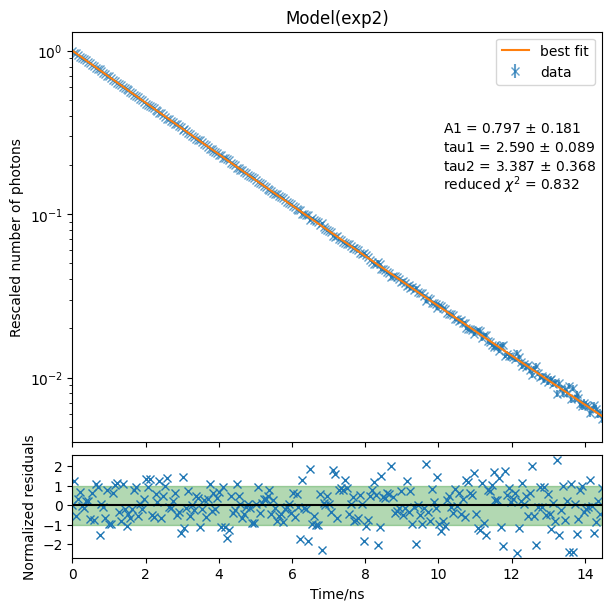

In [8]:
result = EGFP.fit_results[8]
fig,ax = plot_fit(result)

#### For photon number lower than $10^6$, use `'leastsq'` method. DO NOT USE `'cobyla'` (would crash the kernel)
Also, the photon count maybe 0 for time>10ns, which may cause problems in error evaluation. It is suggested to trim the data at 8ns.

In [9]:
EGFP.n_photon = int(1e4)
EGFP.repeat_sim(100)
EGFP.repeat_sim_results(end=int(0.4*380))


In [10]:
EGFP.val_df.iloc[:,2] #access series using df.iloc[row,col]

0   _val    2.783942
1   _val    2.654941
2   _val    2.665452
3   _val    2.752394
4   _val    2.666408
              ...   
95  _val    2.708762
96  _val    2.618765
97  _val    2.629062
98  _val    2.711495
99  _val    2.576724
Name: tau2, Length: 100, dtype: object

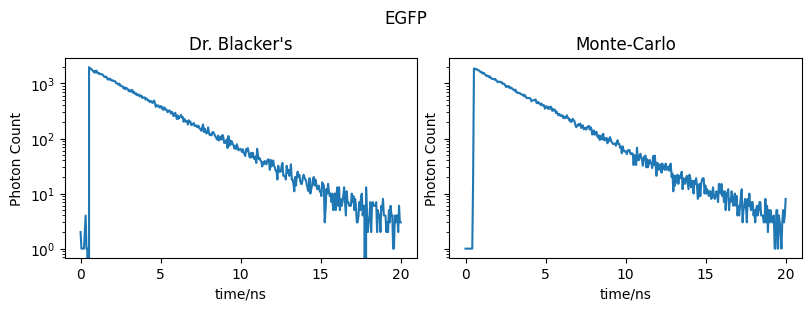

In [23]:
fig,ax = plt.subplots(1,2,figsize = (8,3),sharey = True)
EGFP.n_photon = int(1e5)
EGFP.multi_exp_data()
EGFP.MC_exp()
EGFP.MC_exp_hist()

EGFP.plot(ax[0],y=EGFP.y2)
EGFP.plot(ax[1],y=EGFP.y)
ax[0].set_title("Dr. Blacker's")
ax[1].set_title("Monte-Carlo")
fig.suptitle(r'EGFP')
for i in range(2):
    ax[i].get_legend().remove()
#ax[1].get_yaxis().set_visible(False)
fig.savefig('EGFP_MC_poisson.pdf')

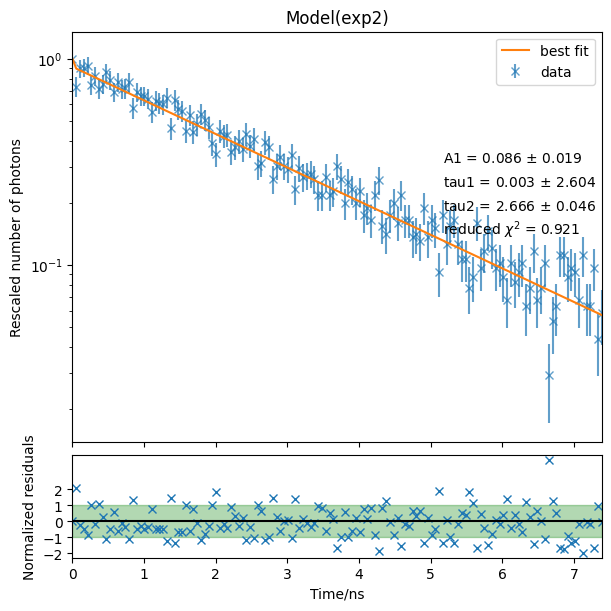

In [12]:
fig,ax = plot_fit(EGFP.fit_results[4])

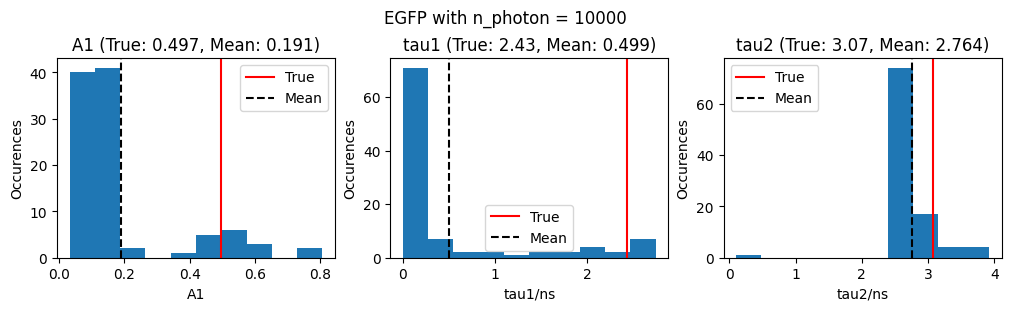

In [14]:
fig,ax=plot_hist(EGFP)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])


AttributeError: 'MinimizerResult' object has no attribute 'plot_fit'

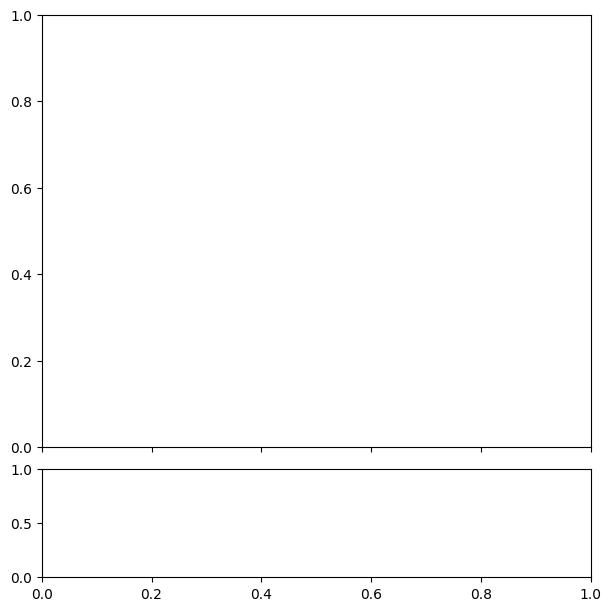

In [10]:
sim.MLEfit(2,sim.t,sim.y2)
plt.plot(sim.mi1)


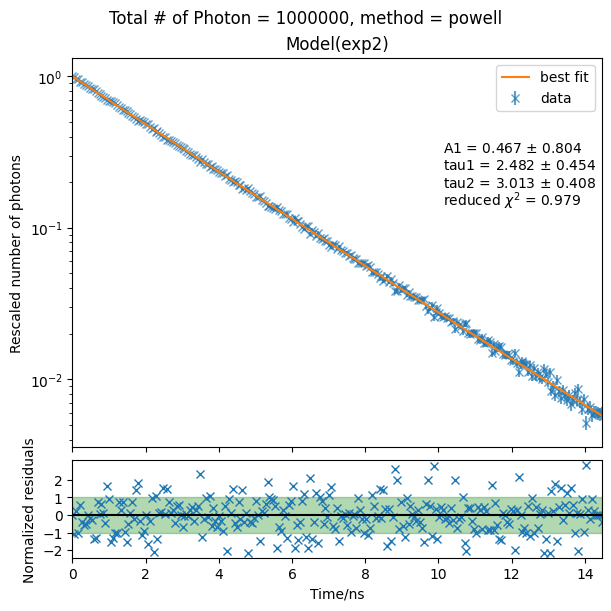

In [5]:
sim=EGFP
sim.n_photon = int(1e6)
sim.multi_exp_data()
sim.fit(exp2,y=sim.y2,method = 'powell')
fig,ax = plot_fit(sim.fit_result)
fig.suptitle(f'Total # of Photon = {sim.n_photon}, method = powell')
plt.savefig('fig/fit_plot_example.pdf')

In [1]:
sim=EGFP
sim.n_photon = int(1e5)
sim.multi_exp_data()
sim.fit(exp2,y=sim.y2,method = 'powell')
fig,ax = plot_fit(sim.fit_result)
fig.suptitle(f'Total # of Photon = {sim.n_photon}, method = powell')

NameError: name 'EGFP' is not defined

IndexError: list index out of range

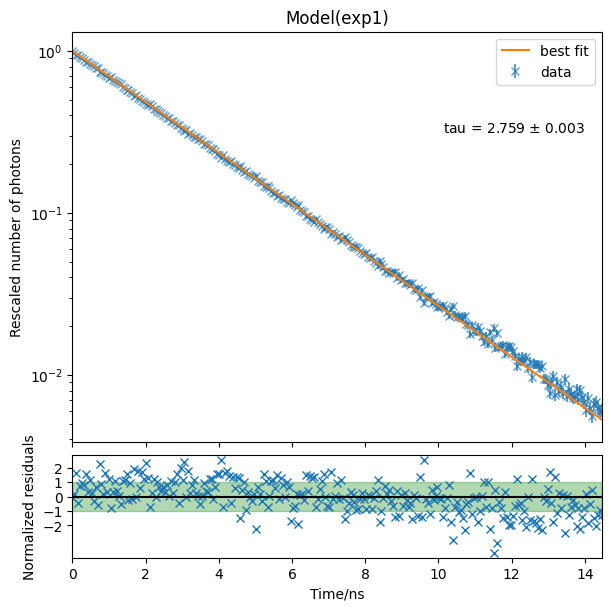

In [9]:
sim=EGFP
sim.n_photon = int(1e6)
sim.multi_exp_data()
sim.fit(exp1,y=sim.y2,method = 'powell')
fig,ax = plot_fit(sim.fit_result)
fig.suptitle(f'Total # of Photon = {sim.n_photon}, method = powell')

IndexError: list index out of range

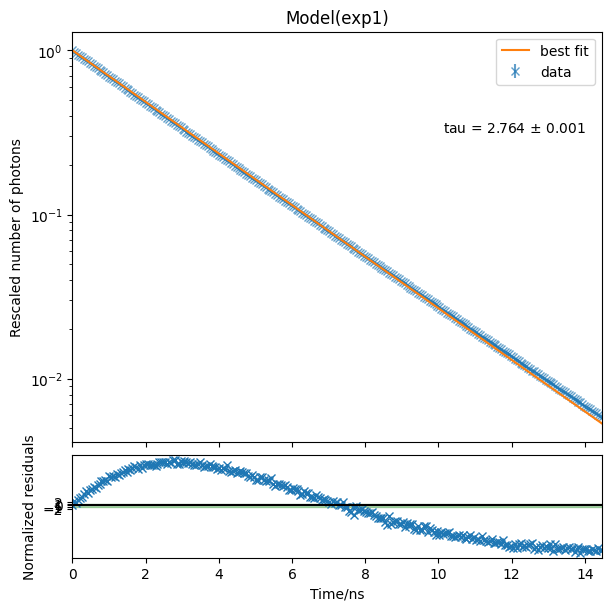

In [5]:
sim=EGFP
sim.n_photon = int(1e9)
sim.multi_exp_data()
sim.fit(exp1,y=sim.y2,method = 'powell')
fig,ax = plot_fit(sim.fit_result)
fig.suptitle(f'Total # of Photon = {sim.n_photon}, method = powell')
#plt.savefig('fig/fit_plot_example.pdf')

In [6]:
sim.fit_result.redchi

358.9551578519335

The following code regenerates data when problems with fit arises, e.g. incorrect evaluation of covariance matrix, NoneType stderr

In [82]:
#DEMO code on regenerating data when problems with fit, e.g. incorrect evaluation of covariance matrix, NoneType stderr
EGFP.n_photon = 10000
EGFP.repeat_sim(100)
results = []
for n in range(len(EGFP.sim_data)):
    y = EGFP.sim_data[n]
    #try until no runtime warning
    while True:
        warnings.filterwarnings("error", category=RuntimeWarning) #treat RuntimeWarning as error
        try:
            EGFP.fit(exp2,y,[EGFP.amp[0]]+EGFP.tau,weights = None,method = 'leastsq')
            if [v.stderr for v in EGFP.par.values()][0] is None:
                print('stderr None')
                raise RuntimeWarning
            break
        #if RuntimeWarning is raised,regenerate data
        except:
            print('bad')
            EGFP.multi_exp_data()
            y = EGFP.y2
            EGFP.sim_data[n]=y
    results.append(EGFP.fit_result)

In [80]:
info_df,par_df = fit_df(results)

In [81]:
info_df

,chisqr,redchi,_val,init_value,stderr,correl
0,223.067359,0.820101,"[0.937, 2.67, 4.07]","[0.497, 2.43, 3.07]","[0.12, 0.0858, 1.46]","[{'tau1': '0.996', 'tau2': '0.998'}, {'A1': '0..."
1,255.222737,0.938319,"[0.0395, 1.41, 2.81]","[0.497, 2.43, 3.07]","[0.0308, 0.579, 0.0238]","[{'tau1': '0.97', 'tau2': '0.984'}, {'A1': '0...."
2,235.482234,0.865744,"[0.0903, 1.44, 2.85]","[0.497, 2.43, 3.07]","[0.0305, 0.249, 0.0249]","[{'tau1': '0.972', 'tau2': '0.985'}, {'A1': '0..."
3,245.429485,0.902314,"[0.999, 2.76, 22.6]","[0.497, 2.43, 3.07]","[0.00323, 0.0131, 91.9]","[{'tau1': '0.952', 'tau2': '0.996'}, {'A1': '0..."
4,259.918687,0.955583,"[0.232, 2.14, 2.93]","[0.497, 2.43, 3.07]","[0.285, 0.486, 0.151]","[{'tau1': '0.996', 'tau2': '0.998'}, {'A1': '0..."
...,...,...,...,...,...,...
95,256.065755,0.941418,"[0.105, 1.53, 2.85]","[0.497, 2.43, 3.07]","[0.0396, 0.261, 0.0308]","[{'tau1': '0.977', 'tau2': '0.988'}, {'A1': '0..."
96,241.604071,0.888250,"[0.447, 2.37, 3.06]","[0.497, 2.43, 3.07]","[0.517, 0.396, 0.331]","[{'tau1': '0.998', 'tau2': '0.999'}, {'A1': '0..."
97,254.239594,0.934704,"[0.977, 2.73, 4.62]","[0.497, 2.43, 3.07]","[0.0711, 0.0642, 3.24]","[{'tau1': '0.994', 'tau2': '0.998'}, {'A1': '0..."
98,211.058071,0.775949,"[0.143, 1.92, 2.88]","[0.497, 2.43, 3.07]","[0.123, 0.416, 0.0708]","[{'tau1': '0.993', 'tau2': '0.996'}, {'A1': '0..."
